In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy import trapz
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

Generate Data ⬇️

In [2]:
def getbJetTrack(mu = 0, sig = 0.5, decay=3, fracDecay=0.05, fracFlat=0.05):
    r = np.random.rand()
    if (r < fracDecay):
        return np.random.exponential(decay)+np.random.normal(0,0.25)
    elif (r < (fracDecay+fracFlat)):
        return 6 * np.random.random_sample()-3 #get flat -3 to 2
    else:
        return np.random.normal(mu,sig) 

def getLFTrack(mu = 0, sig = 0.5, fracFlat=0.05):
    r = np.random.rand()
    if( r < fracFlat):
        return 6 * np.random.random_sample()-3
    else:        
        return np.random.normal(mu,sig)

def getbJetData(NumData, fracDecay=0.05): #get list of NumData number of elements. 
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(4)
        tracks=[]
        for j in range (n):
            tracks.append(getbJetTrack(fracDecay=fracDecay))
        DataSet.append(tracks)
    return DataSet

def getLFJetData(NumData): # get list of NumData number of elements
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(2)
        tracks=[]
        for j in range (n):
            tracks.append(getLFTrack())
        DataSet.append(tracks)
    return DataSet

KNN ⬇️

In [3]:
def DataSameLen(listOfLists): # add 0 to the end of stort list elements
    maxLen=0
    for i in listOfLists:
        if len(i)>maxLen:
            maxLen=len(i)
    for i in listOfLists:
        if len(i)<maxLen:
            while(len(i)<maxLen):
                i.append(0)
    return listOfLists

def getData(NumData): #combines B jet data and LF jet data, NumData: number of data in each, adds indicator at the front
    bj=getbJetData(NumData) #only train uses this
    j=0
    for i in bj:
        bj[j] = [True] + i
        j+=1
    lfj=getLFJetData(NumData)
    k=0
    for i in lfj:
        lfj[k] = [False] + i
        k+=1
    for j in lfj:
        bj.append(j)
    return bj

def dist(elem_train, elem_test): 
    d=0.0
    for i in range(1, len(elem_train)):
        d+=(elem_train[i]-elem_test[i-1])**2
    return np.sqrt(d)

def getNbors(train, elem_test, k):
    distance=[]
    for elem in train:
        distance.append([elem,dist(elem,elem_test)])
    distance.sort(key = lambda ls : ls[1])
    nbors=[]
    for i in range(k):
        nbors.append(distance[i][0])
    return nbors

def BjetProb(train, elem_test, k):
    neigbors=getNbors(train,elem_test,k)
    numTrue=0
    for i in neigbors:
        if (i[0]==True):
            numTrue+=1
    return float(numTrue)/float(len(neigbors))

# Plot the Data

In [4]:
def flatten(inData): 
    dataFlat = np.array([])
    for jet in inData:
        dataFlat = np.append(dataFlat,jet)
    return dataFlat

10


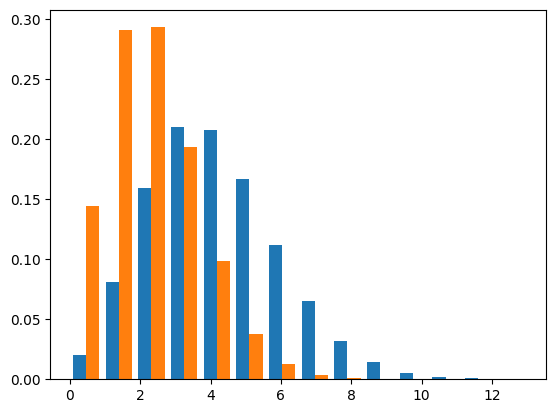

In [5]:
nEvents = 100000

bj=getbJetData(nEvents, fracDecay=0.2) #only train uses this
lf=getLFJetData(nEvents)

length_b = []
for i in bj:
    length_b.append(len(i))
length_lf = []
for i in lf:
    length_lf.append(len(i))
# this is for poisson likelihood
print(max(length_lf))
lenCount, lenBins, lenPatch=plt.hist([length_b,length_lf],bins=np.linspace(0,13,15), density=True)

In [6]:
bjFlat = flatten(bj)

lfFlat = flatten(lf)

print(f"{len(bjFlat)} vs {len(lfFlat)}")

399249 vs 200188


[[0.01101947 0.00944526 0.01079459 0.01191902 0.00944526 0.00967015
  0.00967015 0.00989504 0.0105697  0.01011992 0.00742128 0.00944526
  0.01034481 0.01326835 0.01034481 0.0105697  0.0087706  0.0069715
  0.0087706  0.00922038 0.01034481 0.00899549 0.01191902 0.00989504
  0.00742128 0.00652173 0.00967015 0.00899549 0.01011992 0.00719639
  0.00832083 0.01394301 0.00899549 0.01101947 0.00832083 0.00854571
  0.00787105 0.01034481 0.0069715  0.01169414 0.01214391 0.0087706
  0.00742128 0.01034481 0.00899549 0.00944526 0.0087706  0.00944526
  0.00944526 0.01011992 0.0087706  0.01034481 0.0087706  0.00854571
  0.0105697  0.0105697  0.0087706  0.00967015 0.00832083 0.01259368
  0.00944526 0.00764617 0.00899549 0.00517241 0.0087706  0.00899549
  0.01034481 0.00809594 0.00832083 0.0105697  0.01034481 0.0069715
  0.0069715  0.00809594 0.00674662 0.01146925 0.00944526 0.00787105
  0.00967015 0.01034481 0.00832083 0.01011992 0.01124436 0.00787105
  0.00787105 0.00719639 0.00967015 0.00809594 0.011

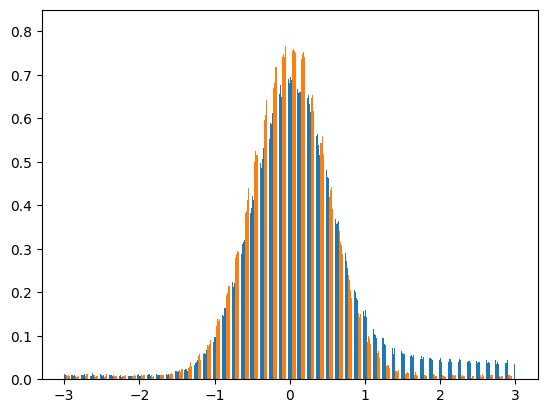

In [7]:
bins = np.linspace(-3,3,500)
#c1, b1, p1 = plt.hist(bjFlat,bins=bins,density=True)
#c2, b2, p2 = plt.hist(lfFlat,bins=bins,histtype="step", density=True)
TrainHistCounts, TrainHistBins, patch = plt.hist([bjFlat,lfFlat],bins=bins,density=True)
#plt.yscale("log")
print(TrainHistCounts)
plt.show()

plot ROC

In [8]:
def pltROCnAUC(counts, bins, label): 
    x=[]
    y=[]
    for i in range(len(counts[0])):
        p = 0
        n = 0
        for j in range(i,len(counts[0])):
            p = p + counts[0][j]*(bins[j+1]-bins[j])
            n = n + counts[1][j]*(bins[j+1]-bins[j])
        x.append(p)
        y.append(n)
    AUC=trapz(x,y)
    print(x)
    print(y)
    plt.plot(y,x,label=label)
    plt.legend()
    return AUC

In [9]:
#getting data
n=1000
train = getData(n)
bj_test=getbJetData(n,fracDecay=0.2)
lf_test=getLFJetData(n)

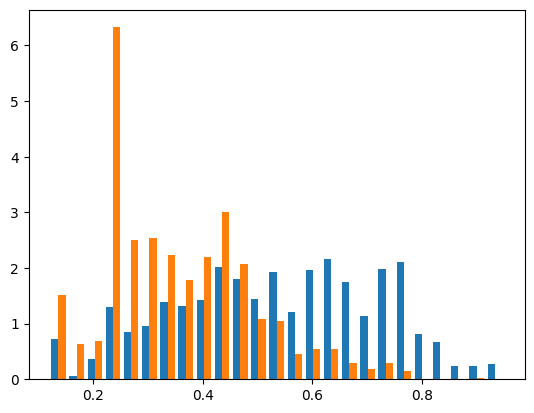

In [10]:
#KNN
train1=copy.deepcopy(train)
DataSameLen(train1)
bj_test1 = copy.deepcopy(bj_test)
DataSameLen(bj_test1)
lf_test1 = copy.deepcopy(lf_test)
DataSameLen(lf_test1)

if (len(bj_test1[0])<len(train1[0])-1):
    for i in bj_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)
if (len(lf_test1[0])<len(train1[0])-1):
    for i in lf_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)

b_prob=[]
lf_prob=[]
for i in bj_test1:
    b_prob.append(BjetProb(train1,i,100))
for i in lf_test1:
    lf_prob.append(BjetProb(train1,i,100))
counts, bins, patches= plt.hist([b_prob,lf_prob], bins=25, density=True)

In [11]:
def trim(floatListList, N):
    res=[]
    falseNum=0
    for i in floatListList:
        if len(i)<N:
            floatListList.remove(i)
            falseNum=falseNum+1
        else:
            mx=[]
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res, falseNum  

def trimTrain(floatListList, N):
    res=[]
    for i in floatListList:
        ind = i[0]
        i.pop(0)
        if len(i)<N:
            floatListList.remove(i)
        else:
            mx=[]
            mx.append(ind)
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res       

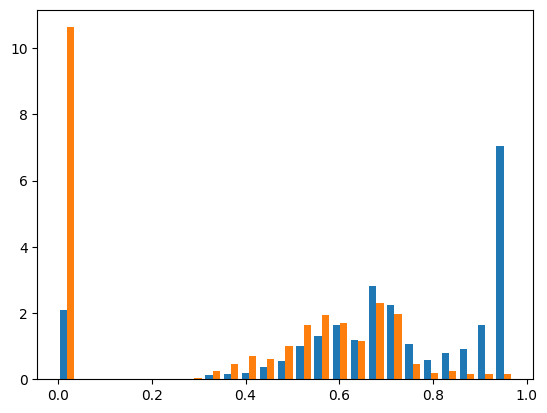

In [12]:
#2d-KNN
train2=copy.deepcopy(train)
train2=trimTrain(train2,2)

bj_test2=copy.deepcopy(bj_test)
lf_test2=copy.deepcopy(lf_test)
bj_test2, bj_fn = trim(bj_test2,2)
lf_test2, lf_fn = trim(lf_test2,2)

b_prob2=[]
lf_prob2=[]
for i in bj_test2:
    b_prob2.append(BjetProb(train2,i,100))
for i in range(bj_fn):
    b_prob2.append(0)
for i in lf_test2:
    lf_prob2.append(BjetProb(train2,i,100))
for i in range(lf_fn):
    lf_prob2.append(0)
counts2, bins2, patches2 = plt.hist([b_prob2,lf_prob2], bins=25, density=True)

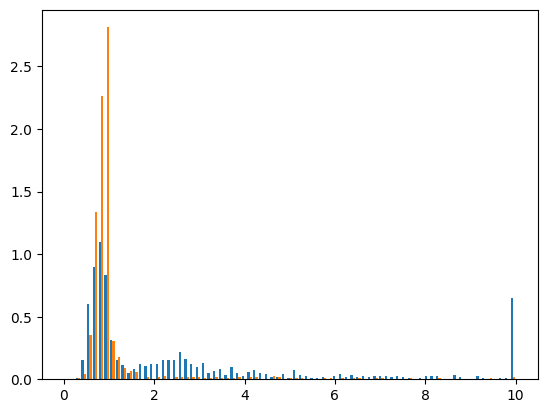

In [13]:
#likelyhood #This uses the histogram for d0
def probInHist(d0, counts, bins): #counts is list of lists
    x=len(bins)-2
    for i in range(len(bins)): 
        if d0 < bins[i]:
            x=i-1
            break
    p=(counts[0][x])/(counts[1][x])
    return p

def likelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi) 
    return p

def llhANDjets(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append([pi,i]) ###############just to see the jets and its likelihood
    return p

bj_test3=copy.deepcopy(bj_test)
lf_test3=copy.deepcopy(lf_test)

bj_p3=likelihood(bj_test3,TrainHistCounts,TrainHistBins)
lf_p3=likelihood(lf_test3,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p3)):
    if bj_p3[i] > 10:
        bj_p3[i] = 10

for i in range(len(lf_p3)):
    if lf_p3[i] > 10:
        lf_p3[i] = 10

bj_p3_ = llhANDjets(copy.deepcopy(bj_test3),TrainHistCounts,TrainHistBins)
lf_p3_ =llhANDjets(copy.deepcopy(lf_test3),TrainHistCounts,TrainHistBins)

bj_p3_.sort(key = lambda ls : ls[0])
lf_p3_.sort(key = lambda ls : ls[0])

counts3, bins3, patches3 = plt.hist([bj_p3,lf_p3], bins=np.linspace(0,10,80), density=True)

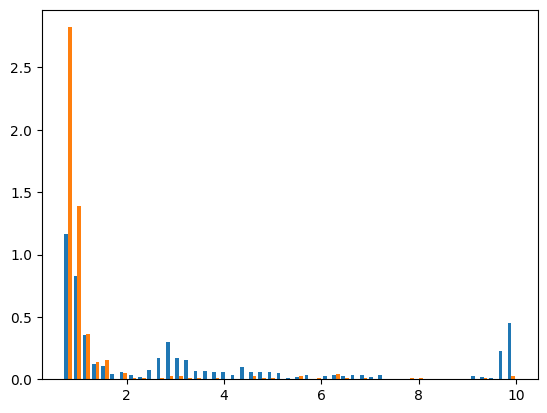

In [14]:
# 2d likelihoood
bj_test5=copy.deepcopy(bj_test2)
lf_test5=copy.deepcopy(lf_test2)

bj_p5=likelihood(bj_test5,TrainHistCounts,TrainHistBins)
lf_p5=likelihood(lf_test5,TrainHistCounts,TrainHistBins)

for i in range(bj_fn):
    bj_p5.append(min(bj_p5))
for i in range(bj_fn):
    lf_p5.append(min(lf_p5))

for i in range(len(bj_p5)):
    if bj_p5[i] > 10:
        bj_p5[i] = 10

for i in range(len(lf_p5)):
    if lf_p5[i] > 10:
        lf_p5[i] = 10

counts5, bins5, patches5 = plt.hist([bj_p5,lf_p5], bins=np.linspace(0.7,10,50), density=True)

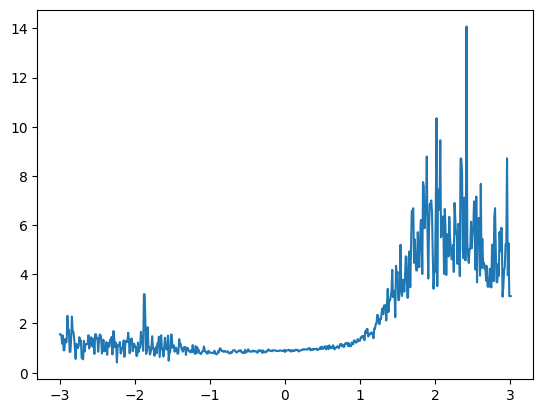

In [15]:
j=-3
list=[]
list.append(j)
while j<=3:
    j+=0.01
    list.append(j)

list2=[]
for d0 in list:
    k=probInHist(d0,TrainHistCounts,TrainHistBins)
    list2.append(k)

plt.plot(list,list2)

/var/folders/vg/yfv452x11j97tr10qw3gk5440000gn/T/ipykernel_17221/1708564958.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  p=(counts[0][x])/(counts[1][x])


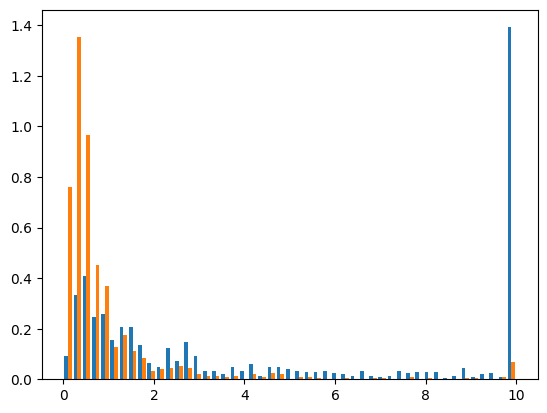

In [16]:
#POISSSON likelyhood
def Poissonlikelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=probInHist(len(i),lenCount,lenBins)
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi)
    return p

bj_test4=copy.deepcopy(bj_test) 
lf_test4=copy.deepcopy(lf_test)

bj_p4=Poissonlikelihood(bj_test4,TrainHistCounts,TrainHistBins)
lf_p4=Poissonlikelihood(lf_test4,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p4)):
    if bj_p4[i] > 10:
        bj_p4[i] = 10

for i in range(len(lf_p4)):
    if lf_p4[i] > 10:
        lf_p4[i] = 10
        
counts4, bins4, patches4 = plt.hist([bj_p4,lf_p4], bins=np.linspace(0,10,50), density=True)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [18]:
trainingData = DataSameLen(copy.deepcopy(train))
Ndimentions=len(trainingData[0])
for i in trainingData:
    if i[0]==True:
        i[0]=1
    else:
        i[0]=0
trainingData = np.array(trainingData)
X = trainingData[:,1:Ndimentions]
y = trainingData[:,0]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

NNmodel = nn.Sequential(
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,1),
   nn.Sigmoid()
)

In [19]:
loss_fn = nn.BCELoss()
optimizer=optim.Adam(NNmodel.parameters(),lr = 0.001)

In [20]:
n_epochs = 100
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = NNmodel(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.6884948015213013
Finished epoch 1, latest loss 0.6891937255859375
Finished epoch 2, latest loss 0.689230740070343
Finished epoch 3, latest loss 0.6892002820968628
Finished epoch 4, latest loss 0.6891672015190125
Finished epoch 5, latest loss 0.6891375184059143
Finished epoch 6, latest loss 0.6891111135482788
Finished epoch 7, latest loss 0.6890873908996582
Finished epoch 8, latest loss 0.6890659332275391
Finished epoch 9, latest loss 0.6890811324119568
Finished epoch 10, latest loss 0.6891082525253296
Finished epoch 11, latest loss 0.6892639398574829
Finished epoch 12, latest loss 0.6895980834960938
Finished epoch 13, latest loss 0.6906635761260986
Finished epoch 14, latest loss 0.693834662437439
Finished epoch 15, latest loss 0.7021067142486572
Finished epoch 16, latest loss 0.7180528044700623
Finished epoch 17, latest loss 0.7292175889015198
Finished epoch 18, latest loss 0.7283656597137451
Finished epoch 19, latest loss 0.7241946458816528
Finished epo

Accuracy 0.7064999938011169


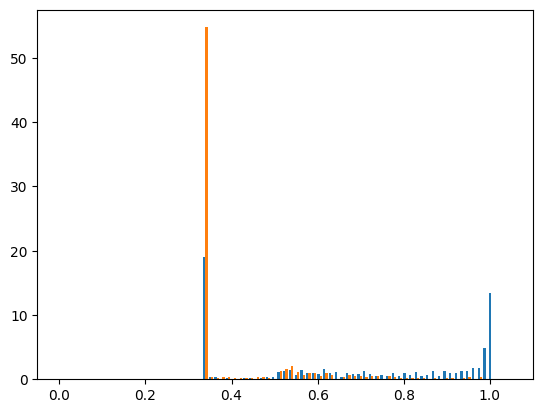

In [21]:
def padding(trainLength, testdata):
    while len(testdata[0])<trainLength:
        for i in testdata:
            i.append(0)
    while len(testdata[0])>trainLength:
        for i in testdata:
            i.remove(min(i))
bj_test6 = DataSameLen(copy.deepcopy(bj_test))
lf_test6 = DataSameLen(copy.deepcopy(lf_test))
padding(len(X[0]),bj_test6)
padding(len(X[0]),lf_test6)

with torch.no_grad():
    y_pred = NNmodel(X)
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

bj_test6 = torch.tensor(bj_test6, dtype=torch.float32)
lf_test6 = torch.tensor(lf_test6, dtype=torch.float32)

with torch.no_grad():
    bj_prob6 = NNmodel(bj_test6)
    lf_prob6 = NNmodel(lf_test6)

counts6, bins6, _ = plt.hist([torch.flatten(bj_prob6),torch.flatten(lf_prob6)],bins=np.linspace(0,1.05,80),density=True)

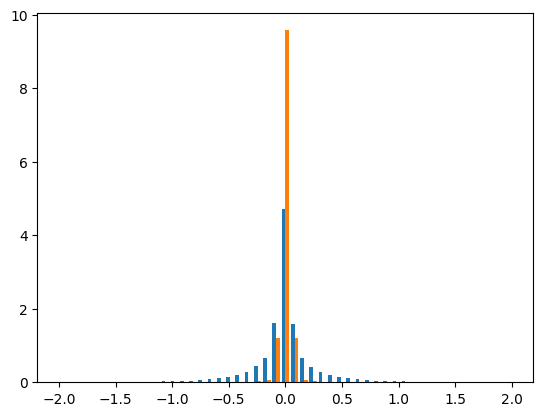

In [22]:
data = pd.read_json("datasetTest100k.json", typ="frame", lines = True, precise_float=True,nrows = 5*100000)
trkData = np.stack(data[3],axis=0)

trk_high_level_name = ["track_2_d0_significance", "track_3_d0_significance",
                       "track_2_z0_significance", "track_3_z0_significance",
                       "n_tracks_over_d0_threshold", "jet_prob", "jet_width_eta", "jet_width_phi"]

for i, trkName in enumerate(trk_high_level_name):
    tmpArr = np.array(trkData[:,i],dtype="float32")
    data[trkName] = tmpArr

vtxData = np.stack(data[4],axis=0)
    
vtx_high_level_name = ["vertex_significance", "n_secondary_vertices", "n_secondary_vertex_tracks",
                       "delta_r_vertex", "vertex_mass", "vertex_energy_fraction"]

for i, vtxName in enumerate(vtx_high_level_name):
    tmpArr = np.array(vtxData[:,i],dtype="float32")
    data[vtxName] = tmpArr

y = data[2]
y = y.values.tolist()

for i in range(len(y)):
    if y[i]==5:
        y[i]=1
    else:
        y[i]=0

jets_trk = []
for i in range(0,200000):
    trkVars = []
    for j in range(len(data[5][i])):
        trkVars.append(data[5][i][j][0])
    jets_trk.append(trkVars)

d0 = []
for i in jets_trk:
    temp = []
    for j in i:
        temp.append(j[0])
    d0.append(temp)

bj=[]
lf=[]
for i in range(len(y)):
    assert len(d0)==len(y)
    if y[i]==1:
        bj.append(d0[i])
    else:
        assert y[i]==0
        lf.append(d0[i])

def flatten(inData): 
    dataFlat = np.array([])
    for jet in inData:
        dataFlat = np.append(dataFlat,jet)
    return dataFlat
bj_d0_flat = flatten(bj)
lf_d0_flat = flatten(lf)
countss, binss, _ = plt.hist([bj_d0_flat,lf_d0_flat], bins=np.linspace(-2,2,50),density=True)

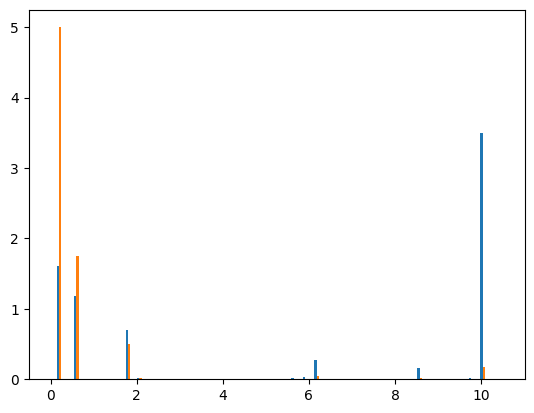

In [25]:
bj_2d = copy.deepcopy(bj)
lf_2d = copy.deepcopy(lf)

for i in bj_2d:
    while len(i)>2:
        i.remove(min(i))
    while len(i)<2:
        i.append(0)

for i in lf_2d:
    while len(i)>2:
        i.remove(min(i))
    while len(i)<2:
        i.append(0)

res_b = likelihood(bj_2d,countss,binss)
res_lf = likelihood(lf_2d,countss,binss)

for i in range(len(res_b)):
    if res_b[i]>10:
        res_b[i]=10

for i in range(len(res_lf)):
    if res_lf[i]>10:
        res_lf[i]=10
        
counts7, bins7, _ = plt.hist([res_b,res_lf],bins=np.linspace(0,10.5,80), density=True)

[1.0, 0.9760000000000002, 0.9740000000000002, 0.9620000000000002, 0.919, 0.891, 0.8590000000000002, 0.8130000000000002, 0.7690000000000001, 0.7220000000000002, 0.655, 0.595, 0.547, 0.48300000000000004, 0.4430000000000001, 0.3780000000000001, 0.30600000000000005, 0.24800000000000003, 0.21000000000000002, 0.14400000000000002, 0.074, 0.047, 0.025, 0.017, 0.009]
[1.0, 0.9500000000000002, 0.929, 0.9060000000000001, 0.6960000000000002, 0.613, 0.529, 0.45500000000000007, 0.396, 0.32300000000000006, 0.22300000000000003, 0.15400000000000003, 0.11800000000000001, 0.083, 0.068, 0.049999999999999996, 0.032, 0.022000000000000002, 0.016, 0.006, 0.001, 0.001, 0.001, 0.001, 0.0]
[1.0, 0.918918918918919, 0.918918918918919, 0.918918918918919, 0.918918918918919, 0.918918918918919, 0.918918918918919, 0.918918918918919, 0.918918918918919, 0.9135135135135135, 0.907027027027027, 0.8994594594594595, 0.8854054054054054, 0.8637837837837837, 0.8248648648648649, 0.774054054054054, 0.7102702702702703, 0.6637837837

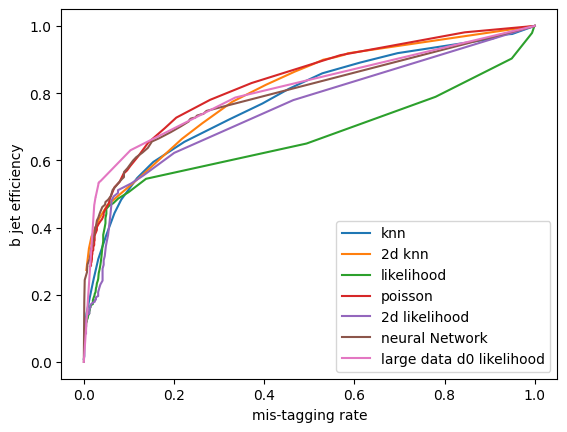

In [26]:
area1 = pltROCnAUC(counts, bins, "knn")
area2 = pltROCnAUC(counts2, bins2, "2d knn")
area3 = pltROCnAUC(counts3, bins3, "likelihood")
area4 = pltROCnAUC(counts4, bins4, "poisson")
area5 = pltROCnAUC(counts5, bins5, "2d likelihood")
area6 = pltROCnAUC(counts6, bins6, "neural Network")
area7 = pltROCnAUC(counts7, bins7, "large data 2 d0 likelihood")

plt.ylabel("b jet efficiency")
plt.xlabel("mis-tagging rate")

print("AUC of knn:",-area1)
print("AUC of 2d knn:",-area2)
print("AUC of likelihood:",-area3)
print("AUC of poisson likelihood:",-area4)
print("AUC of 2d likelihood:",-area5)
print("AUC of neural network:",-area6)
print("AUC of 100k data 2d likelihoood",-area7)